In [1]:
import os
import sys

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))

from src.utils.utils import *

# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

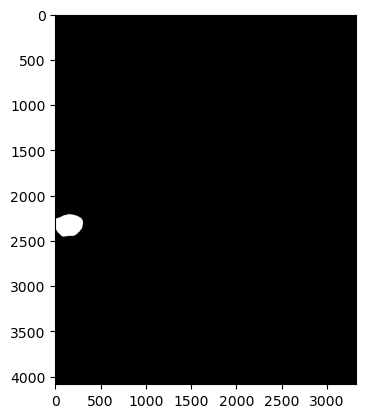

In [2]:
import matplotlib.pyplot as plt

metadata = load_json("extracted_metadata_INBREAST", "../../outputs/mamografia/extracted_metadata")
cropped_path = metadata[3]['metadata_csv']['cropped_image_path']
img = load_inbreast_mask(cropped_path)

fig = plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

# Modelos preditivo

## Configuração

In [3]:
SELECTED_DATABASE = "MIAS"

## Importação e análise dos conjuntos de dados

Iniciamos importando o conjunto de dados e realizamos a visualização das 5 primeiras linhas para verificar a estrutura dos dados.

In [4]:
breast_cancer_df = None

match SELECTED_DATABASE:
    case "CMMD":
        breast_cancer_df = pd.read_csv("../../outputs/mamografia/matriz_glcm_features/matriz_features_glcm_CMMD.csv")
    case "CBIS-DDSM":
        breast_cancer_df = pd.read_csv("../../outputs/mamografia/matriz_glcm_features/matriz_features_glcm_CBIS-DDSM.csv")
    case "INBREAST":
        breast_cancer_df = pd.read_csv("../../outputs/mamografia/matriz_glcm_features/matriz_features_glcm_INBREAST.csv")
    case "MIAS":
        breast_cancer_df = pd.read_csv("../../outputs/mamografia/matriz_glcm_features/matriz_features_glcm_MIAS.csv")
    case _:
        raise Exception("Database not found!")
    
breast_cancer_df.head()

,dissimilarity_ang_0_dist_1,dissimilarity_ang_45_dist_1,dissimilarity_ang_90_dist_1,dissimilarity_ang_135_dist_1,dissimilarity_ang_0_dist_3,dissimilarity_ang_45_dist_3,dissimilarity_ang_90_dist_3,dissimilarity_ang_135_dist_3,correlation_ang_0_dist_1,correlation_ang_45_dist_1,...,energy_ang_0_dist_1,energy_ang_45_dist_1,energy_ang_90_dist_1,energy_ang_135_dist_1,energy_ang_0_dist_3,energy_ang_45_dist_3,energy_ang_90_dist_3,energy_ang_135_dist_3,pathology,image_path
0,1.770133,2.286580,1.691272,1.960602,3.421132,3.492933,3.177814,2.834678,0.999292,0.998775,...,0.043258,0.041618,0.044790,0.042723,0.038038,0.038508,0.040929,0.040071,Benign,D:/mathe/Documents/BancoDados_IC/Mamografia/MI...
1,1.246007,1.331877,0.921506,1.352017,2.226141,1.817961,1.467794,1.889652,0.995981,0.994838,...,0.062490,0.062114,0.075834,0.061525,0.050647,0.055793,0.064539,0.054605,Benign,D:/mathe/Documents/BancoDados_IC/Mamografia/MI...
2,1.753107,2.108589,1.755367,2.075266,3.255263,2.887634,2.528947,2.804400,0.989984,0.985712,...,0.053241,0.048751,0.052407,0.049765,0.042331,0.043433,0.044936,0.044625,Benign,D:/mathe/Documents/BancoDados_IC/Mamografia/MI...
3,1.753107,2.108589,1.755367,2.075266,3.255263,2.887634,2.528947,2.804400,0.989984,0.985712,...,0.053241,0.048751,0.052407,0.049765,0.042331,0.043433,0.044936,0.044625,Benign,D:/mathe/Documents/BancoDados_IC/Mamografia/MI...
4,2.299767,2.577988,1.912354,2.634793,4.543050,3.711182,3.366763,4.018066,0.986102,0.982539,...,0.042799,0.040907,0.046075,0.040068,0.032598,0.035548,0.036518,0.034015,Benign,D:/mathe/Documents/BancoDados_IC/Mamografia/MI...


Como último passo, verificamos a distribuição das classes. 

In [5]:
breast_cancer_df["pathology"].value_counts(normalize=True)

Benign       0.571429
Malignant    0.428571
Name: pathology, dtype: float64

## Pré-Processamento

In [6]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
if SELECTED_DATABASE == "CBIS-DDSM":
    breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "BENIGN_WITHOUT_CALLBACK"]
elif SELECTED_DATABASE == "INBREAST":
    breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "NORMAL"]

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology", "image_path"], axis=1), breast_cancer_df["pathology"])

# Balanceamento de classes
if SELECTED_DATABASE == "CMMD":
    nm = NearMiss(version=1)
    X, y = nm.fit_resample(X, y)
elif SELECTED_DATABASE == "INBREAST" or SELECTED_DATABASE == "MIAS":
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

""" # Salva e retira image_path
image_paths_train = X_train["image_path"]
image_paths_test = X_test["image_path"]
X_train = X_train.drop("image_path", axis=1)
X_test = X_test.drop("image_path", axis=1) """

# Padroniza os dados
columns = X_train.columns
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

# Tratamos os rótulos categóricos
if SELECTED_DATABASE in ["CMMD", "MIAS"]:
    y_train = y_train.map({"Benign": 0, "Malignant": 1})
    y_test = y_test.map({"Benign": 0, "Malignant": 1})
elif SELECTED_DATABASE in ['CBIS-DDSM',  'INBREAST']:
    y_train = y_train.map({"BENIGN": 0, "MALIGNANT": 1})
    y_test = y_test.map({"BENIGN": 0, "MALIGNANT": 1})
    
print("y_train: ", y_train.value_counts(normalize=True))
print("y_test: ", y_test.value_counts(normalize=True))

y_train:  0    0.536842
1    0.463158
Name: pathology, dtype: float64
y_test:  1    0.585366
0    0.414634
Name: pathology, dtype: float64


## Treinamento dos modelos

### Variáveis

In [7]:
angles = ["0", "45", "90", "135"]
distances = ['1', '3']
threshold = 0.5 # Definir o limiar
kf = KFold(n_splits=5)

### Funções

In [8]:
# Função para criar o modelo do Keras
def create_mlp_model(shape):
    model = Sequential()
    model.add(Dense(50, input_dim=shape, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model


def evaluate_mlp_model(model, data, target, n_splits, n_epochs, batch_size, threshold=0.5):
    kf = KFold(n_splits = n_splits)
    
    acc = []
    for train_index, test_index in kf.split(data, target): 
        model.fit(data.iloc[train_index], target.iloc[train_index], 
                  epochs=n_epochs, batch_size=batch_size)
        
        y_pred = model.predict(data.iloc[test_index])
        
        # Definir o limiar
        threshold = threshold

        # Transformar as saídas em rótulos
        y_pred = (y_pred > threshold).astype(int)
        
        acc.append(accuracy_score(y_pred, target.iloc[test_index]))

    return (np.array(acc)).mean() * 100

### KNeighborsClassifier

In [9]:
# Treina com todos os angulos e distancias
knn_model = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean", algorithm="auto")

knn_model.fit(X_train, y_train)
predict = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, predict) * 100
#accuracy = (cross_val_score(knn_model, X_test, y_test, cv=kf).mean()) * 100

# predicts = {"KNeighborsClassifier": {"all": predict}}
scores = {"KNeighborsClassifier": {"all": {"accuracy_score": accuracy}}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]

        knn_model = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean", algorithm="auto")
        # knn_model.fit(X_train_filtered, y_train)
        # predict = knn_model.predict(X_test_filtered)
        # accuracy = accuracy_score(y_test, predict) * 100
        accuracy = (cross_val_score(knn_model, X_test_filtered, y_test, cv=kf).mean()) * 100

        #predicts["KNeighborsClassifier"][f"ang_{angle}_dist_{distance}"] = predict
        scores["KNeighborsClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} """

' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n\n        knn_model = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean", algorithm="auto")\n        # knn_model.fit(X_train_filtered, y_train)\n        # predict = knn_model.predict(X_test_filtered)\n        # accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = (cross_val_score(knn_model, X_test_filtered, y_test, cv=kf).mean()) * 100\n\n        #predicts["KNeighborsClassifier"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["KNeighborsClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} '

### Random Forest Classifier

In [10]:
# Treina com todos os angulos e distancias
random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=10, criterion="gini", 
                                             min_samples_leaf=3, min_samples_split=2)
random_forest_model.fit(X_train, y_train)
predict = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, predict) * 100
#accuracy = (cross_val_score(random_forest_model, X_test, y_test, cv=kf).mean()) * 100

# predicts["RandomForestClassifier"] = {"all": predict}
scores["RandomForestClassifier"] = {"all": {"accuracy_score": accuracy}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]
        
        random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=10, criterion="gini", 
                                                     min_samples_leaf=3, min_samples_split=2)
        
        # random_forest_model.fit(X_train_filtered, y_train)
        # predict = random_forest_model.predict(X_test_filtered)
        # accuracy = accuracy_score(y_test, predict) * 100
        accuracy = (cross_val_score(random_forest_model, X_test_filtered, y_test, cv=kf).mean()) * 100

        # predicts["RandomForestClassifier"][f"ang_{angle}_dist_{distance}"] = predict
        scores["RandomForestClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} """

' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n        \n        random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=10, criterion="gini", \n                                                     min_samples_leaf=3, min_samples_split=2)\n        \n        # random_forest_model.fit(X_train_filtered, y_train)\n        # predict = random_forest_model.predict(X_test_filtered)\n        # accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = (cross_val_score(random_forest_model, X_test_filtered, y_test, cv=kf).mean()) * 100\n\n        # predicts["RandomForestClassifier"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["RandomForestClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} '

### Support Vector Machines

In [11]:
# Treina com todos os angulos e distancias
svm_model = svm.SVC(C=10, gamma='scale', kernel='linear')
svm_model.fit(X_train, y_train)
predict = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, predict) * 100
#accuracy = (cross_val_score(svm_model, X_test, y_test, cv=kf).mean()) * 100

# predicts["SVM"] = {"all": predict}
scores["SVM"] = {"all": {"accuracy_score": accuracy}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]

        svm_model = svm.SVC(C=10, gamma='scale', kernel='linear')
        
        # svm_model.fit(X_train_filtered, y_train)
        # predict = svm_model.predict(X_test_filtered)
        # accuracy = accuracy_score(y_test, predict) * 100
        accuracy = (cross_val_score(svm_model, X_test_filtered, y_test, cv=kf).mean()) * 100

        # predicts["SVM"][f"ang_{angle}_dist_{distance}"] = predict
        scores["SVM"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} """

' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n\n        svm_model = svm.SVC(C=10, gamma=\'scale\', kernel=\'linear\')\n        \n        # svm_model.fit(X_train_filtered, y_train)\n        # predict = svm_model.predict(X_test_filtered)\n        # accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = (cross_val_score(svm_model, X_test_filtered, y_test, cv=kf).mean()) * 100\n\n        # predicts["SVM"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["SVM"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} '

### Boosted Tree Classifier

In [12]:
# Treina com todos os angulos e distancias
boosted_tree_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
boosted_tree_model.fit(X_train, y_train)
predict = boosted_tree_model.predict(X_test)
accuracy = accuracy_score(y_test, predict) * 100

scores["GradientBoostingClassifier"] = {"all": {"accuracy_score": accuracy}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]

        boosted_tree_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
        
        # boosted_tree_model.fit(X_train_filtered, y_train)
        # predict = boosted_tree_model.predict(X_test_filtered)
        # accuracy = accuracy_score(y_test, predict) * 100
        accuracy = (cross_val_score(boosted_tree_model, X_test_filtered, y_test, cv=kf).mean()) * 100
        
        # predicts["GradientBoostingClassifier"][f"ang_{angle}_dist_{distance}"] = predict
        scores["GradientBoostingClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} """

' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n\n        boosted_tree_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)\n        \n        # boosted_tree_model.fit(X_train_filtered, y_train)\n        # predict = boosted_tree_model.predict(X_test_filtered)\n        # accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = (cross_val_score(boosted_tree_model, X_test_filtered, y_test, cv=kf).mean()) * 100\n        \n        # predicts["GradientBoostingClassifier"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["GradientBoostingClassifier"][f"ang_{angle}_dist_{distance}"] = {"accuracy_score": accuracy} '

### Multilayer Perceptron

In [13]:
# Treina com todos os angulos e distancias
mlp = create_mlp_model(X_test.shape[1])
mlp.fit(X_train, y_train, epochs=100, batch_size=5, verbose=0)

predict = mlp.predict(X_test)
predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
accuracy = accuracy_score(y_test, predict) * 100

scores["MultilayerPerceptron"] = {"all": {"accuracy_score": accuracy}}

""" for distance in distances:
    for angle in angles:
        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column ]
        X_train_filtered = X_train.loc[::, columns]
        X_test_filtered = X_test.loc[::, columns]

        #mlp = create_model(X_test_filtered.shape[1])
        #mlp.fit(X_train_filtered, y_train, epochs=100, batch_size=5, verbose=0)
        #predict = mlp.predict(X_test_filtered)
        
        #predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
        #accuracy = accuracy_score(y_test, predict) * 100
        accuracy = evaluate_mlp_model(create_mlp_model(X_test_filtered.shape[1]),
                              X_test_filtered, y_test, 5, 100, 5)

        #predicts["MultilayerPerceptron"][f"ang_{angle}_dist_{distance}"] = predict
        scores["MultilayerPerceptron"][f"ang_{angle}_dist_{distance}"] = { "accuracy_score": accuracy } """

2/2 [==============================] - 0s 3ms/step


' for distance in distances:\n    for angle in angles:\n        columns = [column for column in X_test.columns if f"ang_{angle}_dist_{distance}" in column ]\n        X_train_filtered = X_train.loc[::, columns]\n        X_test_filtered = X_test.loc[::, columns]\n\n        #mlp = create_model(X_test_filtered.shape[1])\n        #mlp.fit(X_train_filtered, y_train, epochs=100, batch_size=5, verbose=0)\n        #predict = mlp.predict(X_test_filtered)\n        \n        #predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos\n        #accuracy = accuracy_score(y_test, predict) * 100\n        accuracy = evaluate_mlp_model(create_mlp_model(X_test_filtered.shape[1]),\n                              X_test_filtered, y_test, 5, 100, 5)\n\n        #predicts["MultilayerPerceptron"][f"ang_{angle}_dist_{distance}"] = predict\n        scores["MultilayerPerceptron"][f"ang_{angle}_dist_{distance}"] = { "accuracy_score": accuracy } '

## Avaliação dos modelos

### Acurácia

In [14]:
scores_knn = pd.DataFrame(scores["KNeighborsClassifier"])
scores_random_forest = pd.DataFrame(scores["RandomForestClassifier"])
scores_svm = pd.DataFrame(scores["SVM"])
scores_boosted_tree = pd.DataFrame(scores["GradientBoostingClassifier"])
scores_perceptron = pd.DataFrame(scores["MultilayerPerceptron"])

merged_df = pd.concat([scores_knn, scores_random_forest, scores_svm, scores_boosted_tree,
                       scores_perceptron], axis=0).reset_index(drop=True)
merged_df['model'] = ['KNN', 'Random Forest', 'SVM', 'Boosted Tree', 'Multilayer Perceptron']

columns = merged_df.columns.tolist()
columns.remove('model')

merged_df = merged_df[['model', *columns]]
merged_df

,model,all
0,KNN,60.975610
1,Random Forest,58.536585
2,SVM,56.097561
3,Boosted Tree,70.731707
4,Multilayer Perceptron,60.975610
